# PageRank with DGL Message Passing
<br>
In DGL, the message passing and feature transformations are all User-Defined Functions (UDFs).

In [1]:
import networkx as nx
import dgl
import torch as th
import matplotlib.pyplot as plt
from matplotlib import style

plt.style.use(['dark_background'])

The PageRank Algorithm
----------------------
In each iteration of PageRank, every node (web page) first scatters its
PageRank value uniformly to its downstream nodes. The new PageRank value of
each node is computed by aggregating the received PageRank values from its
neighbors, which is then adjusted by the damping factor:

\begin{align}PV(u) = \frac{1-d}{N} + d \times \sum_{v \in \mathcal{N}(u)}
   \frac{PV(v)}{D(v)}\end{align}

where $N$ is the number of nodes in the graph; $D(v)$ is the
out-degree of a node $v$; and $\mathcal{N}(u)$ is the neighbor
nodes.

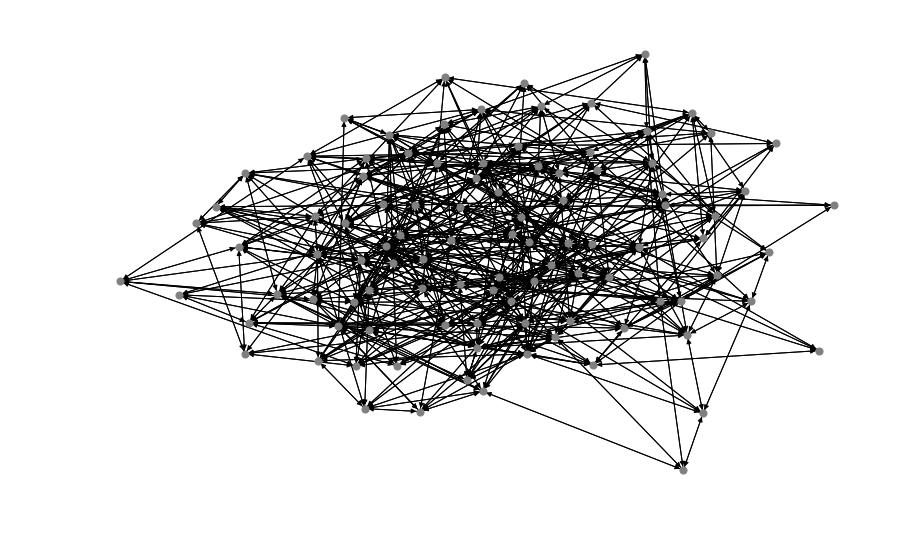

In [2]:
N = 100  # number of nodes
DAMP = 0.85  # damping factor
K = 10  # number of iterations

# create a graph on networkx and convert it to dgl
g = nx.nx.erdos_renyi_graph(N, 0.1)
g = dgl.DGLGraph(g)
plt.figure(figsize=(12,7))
nx.draw(g.to_networkx(), node_size=50, node_color=[[.5, .5, .5,]])
plt.show()

### According to the algorithm, PageRank consists of two phases in a typical scatter-gather pattern. 
1. Initialize the PageRank value of each node to $1/N$ 
2. Store each node’s out-degree (i.e. #edges that have node *i* as a source) as a node feature

In [3]:
g.ndata['pv'] = th.ones(N) / N # step 1 - init page value
g.ndata['deg'] = g.out_degrees(g.nodes()).float() # step 2 - compute degree

### The message function divides every node’s PageRank value by its out-degree and passes the result as message to its neighbors:

### In DGL, the message functions are expressed as Edge UDFs. Edge UDFs take in a single argument edges, which has three members:

*  *src*: source node features
*  *dst*: destination node features
*  *data*: edge features

In [24]:
def pagerank_message_func(edges):
    # the function computes messages only from source node features
    return {'pv' : edges.src['pv'] / edges.src['deg']}

### the reduce function removes and aggregates the messages from its **mailbox**, and computes its new PageRank value:

### The reduce functions are Node UDFs. Node UDFs have a single argument nodes, which has two members:
*  *data*: contains the node features
*  *mailbox*: contains all incoming message features, stacked along the second dimension (hence the dim=1 argument).

<br>

N.B. the **mailbox** is given only by the neighbors' features

In [25]:
def pagerank_reduce_func(nodes):
    msgs = th.sum(nodes.mailbox['pv'], dim=1)
    pv = (1 - DAMP) / N + DAMP * msgs
    return {'pv' : pv}

The reduce functions are **Node UDFs**.  Node UDFs have a single argument
``nodes``, which has two members ``data`` and ``mailbox``.  ``data``
contains the node features while ``mailbox`` contains all incoming message
features, stacked along the second dimension (hence the ``dim=1`` argument).

The message UDF works on a batch of edges, whereas the reduce UDF works on
a batch of edges but outputs a batch of nodes. Their relationships are as
follows:

![](https://i.imgur.com/kIMiuFb.png)


We register the message function and reduce function, which will be called
later by DGL.




In [26]:
g.register_message_func(pagerank_message_func)
g.register_reduce_func(pagerank_reduce_func)

In [20]:
# Naive approach not scalable to LARGE graphs
def pagerank_naive(g):
    # Phase #1: send out messages along all edges.
    for u, v in zip(*g.edges()):
        g.send((u, v))
    # Phase #2: receive messages to compute new PageRank values.
    for v in g.nodes():
        g.recv(v)

In [10]:
# Version 2 - Uses computation on a batches message and reduce functions on multiple nodes and edges at once
def pagerank_batch(g):
    g.send(g.edges())
    # to perform reduce on all nodes, even with different #messages, DGL automatically solves the problem by grouping
    # the nodes by the number of incoming messages, and calling the reduce function for each group
    g.recv(g.nodes())

# Higher level APIs

In [12]:
def pagerank_level2(g):
    # Besides update_all, we also have pull, push, and send_and_recv
    g.update_all()

### DGL also provides builtin functions. For example, two builtin functions can be used in the PageRank example
<br>

*  **dgl.function.copy_src(src, out)**: is an edge UDF that computes the output using the source node feature data. User needs to specify the name of the source feature data (src) and the output name (out)
<br>

*  **dgl.function.sum(msg, out)**: is a node UDF that sums the messages in the node’s mailbox. User needs to specify the message name (msg) and the output name (out).

In [27]:
# In case of PageRank
import dgl.function as fn

def pagerank_builtin(g):
    g.ndata['pv'] = g.ndata['pv'] / g.ndata['deg']
    # This will override the previously registered UDFs.
    g.update_all(message_func=fn.copy_src(src='pv', out='m'),
                 reduce_func=fn.sum(msg='m',out='m_sum'))
    g.ndata['pv'] = (1 - DAMP) / N + DAMP * g.ndata['m_sum']

In [42]:
import time
start = time.time()
for k in range(K):
    # Uncomment the corresponding line to select different version.
    # pagerank_naive(g) # 2.95s
    # pagerank_batch(g) # 0.4s
    # pagerank_level2(g) # 0.3s
    pagerank_builtin(g) # 0.1s
print("Elapsed time: {:.2f}s".format(time.time()-start))
print(g.ndata['pv'])

Elapsed time: 0.01s
tensor([0.0065, 0.0105, 0.0108, 0.0137, 0.0113, 0.0106, 0.0121, 0.0089, 0.0089,
        0.0048, 0.0090, 0.0065, 0.0086, 0.0127, 0.0073, 0.0090, 0.0098, 0.0064,
        0.0127, 0.0072, 0.0095, 0.0129, 0.0066, 0.0120, 0.0138, 0.0104, 0.0086,
        0.0128, 0.0128, 0.0112, 0.0110, 0.0148, 0.0049, 0.0116, 0.0104, 0.0091,
        0.0062, 0.0139, 0.0064, 0.0120, 0.0064, 0.0096, 0.0097, 0.0131, 0.0107,
        0.0136, 0.0113, 0.0155, 0.0121, 0.0108, 0.0113, 0.0122, 0.0090, 0.0072,
        0.0130, 0.0106, 0.0074, 0.0079, 0.0120, 0.0095, 0.0065, 0.0089, 0.0128,
        0.0088, 0.0080, 0.0098, 0.0098, 0.0131, 0.0090, 0.0114, 0.0106, 0.0103,
        0.0114, 0.0058, 0.0110, 0.0107, 0.0087, 0.0093, 0.0129, 0.0088, 0.0083,
        0.0083, 0.0083, 0.0098, 0.0153, 0.0129, 0.0105, 0.0107, 0.0151, 0.0057,
        0.0080, 0.0049, 0.0066, 0.0086, 0.0096, 0.0080, 0.0122, 0.0105, 0.0087,
        0.0090])
